## We Can Control Brighter-Fatter Effect in ImSim

Author: Michael Wood-Vasey  
Date: 2018-08-24

#### Abstract

The size difference between XX, YY measured moments and PSF XX, YY model moments is well controlled on example ImSim Run 1.2i image when applying a brighter-fatter correction kernel generated from a pair of high-intensity flats.

#### Details
1. Generate Brighter-Fatter Kernel with [Make Brighter-Fatter Notebook](make_brighter_fatter_kernel.ipynb)
   - Uses a pair of high-intensity (80k e-/pix) flats generated by Jim Chiang
2. Test runs from [Test BF Script](../scripts/test_bf.sh)
   - Uses a full focal plane ImSim image generated by Jim Chiang
   - This script generates an ImSim repo with a rerun without brighter-fatter applied and one with brighter-fatter applied.
3. This Notebook then reads in the catalogs and plots the difference between the object XX, YY measured moments and the PSF XX, YY model moments for each object.

#### Notes:
* The steps above were run in total using the following branches:  
  - `obs_base`  branch `tickets/DM-13293`
  - `obs_lsstCam` branch `tickets/DM-15509`
  - `ip_isr` branch `tickets/DM-13293`
  - `cp_pipe` branch `tickets/DM-13293`  to generate the Brighter-Fatter kernel
* I ran the `processCcd.py` processing on `lsst-dev01.ncsa.illinois.edu` at NCSA due to some small hiccups at NERSC getting the `ip_isr` branch compiled against an up-to-date weeklies.  Nothing serious.  Heather Kelly is on the case and this should all be resolved shortly.

#### Acknowledgments:
Significant thanks to
* Merlin Fisher-Levine for adapting and explaining the Brighter-Fatter kernel code to me
* Jim Chiang for generate simulated images and flats.
* The specific plotting code in this Notebook was adapted from code by Merlin Fisher-Levine  
from code by Lauren MacArthur.


In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
%matplotlib inline

In [11]:
from copy import copy

def get_size_shape_mag_diff(visits, partial_data_id):
    """Return magnitudes, percentage size difference, and percentage shape difference between object and PSF model."""
    star_xx = []
    star_yy = []
    model_xx = []
    model_yy = []
    mags = []
    for visit in visits:
        data_id = copy(partial_data_id)
        data_id['visit'] = visit
        try:
            cat = butler.get('src', dataId=data_id)  
            calib = butler.get('calexp_calib', dataId=data_id)
        except dafPersist.NoResults as e:
            print(e)
            continue

        calib.setThrowOnNegativeFlux(False)

        mask = (cat['calib_psfUsed'] == 1) #& (cat['base_PixelFlags_flag_interpolated'] == 0)
        stars = cat[mask]
        star_xx.extend(stars['base_SdssShape_xx'])
        star_yy.extend(stars['base_SdssShape_yy'])
        model_xx.extend(stars['base_SdssShape_psf_xx'])
        model_yy.extend(stars['base_SdssShape_psf_yy'])
        mags.extend(calib.getMagnitude(cat['base_PsfFlux_flux']))
    
    mags = np.asarray(mags)
    star_xx, star_yy = np.asarray(star_xx), np.asarray(star_yy)
    model_xx, model_yy = np.asarray(model_xx), np.asarray(model_yy)
    
    star_sizes = np.sqrt((star_xx + star_yy)/2)
    model_sizes = np.sqrt((model_xx + star_yy)/2)
    diffs = 100*(star_sizes - model_sizes)/model_sizes

    print(len(mags))
    print(len(diffs))
    
    return mags, diffs

In [4]:
def plot(mags, diffs, title='', plot_filename=None,
         bright_threshold=17.5,
         maxDiff=12, nStdev=3.0, deltaMin=0.0, ptSize=25, fontsize=20, color='b'):
    left, width = 0.12, 0.62
    bottom, height = 0.10, 0.85 # had to change height to make it save correctly
    left_h = left + width + 0.03
    bottom_h = bottom + width + 0.02
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_h, bottom, 0.20, height]

    bright = np.where(mags < bright_threshold)
        
    all_color, bright_color = 'blue', 'orange'

    fig = plt.figure(figsize=(15,10))
    axScatter = plt.axes(rect_scatter)
    if title: plt.title(title, fontsize=25)
    axHisty = plt.axes(rect_histy)

    scatter_kwargs = {'s': 1.3*ptSize, 'marker': 'o', 'alpha': 0.15}
    axScatter.scatter(mags, diffs, facecolors=all_color, edgecolors=all_color, **scatter_kwargs)
    axScatter.scatter(mags[bright], diffs[bright], facecolors=all_color, edgecolors=bright_color, **scatter_kwargs)

    axScatter.axhline(0, ls='--', color="0.4")
    
    # Show bin in magnitudes
    mag_bin_size = 0.1  # mag
    mag_bins = np.arange(16, 21, mag_bin_size)
    bin_index = np.digitize(mags, mag_bins)

    axScatterY1 = axScatter.get_ylim()[0]
    axScatterY2 = axScatter.get_ylim()[1]
    nyDecimal = int(-1.0*np.around(np.log10(0.05*abs(axScatterY2 - (axScatterY1 - deltaMin))) - 0.5))
    yBinwidth = max(0.5/10**nyDecimal, np.around(0.02*abs(axScatterY2 - (axScatterY1 - deltaMin)), nyDecimal))

    yBins = np.arange((axScatterY1 - deltaMin) - 0.5*yBinwidth, axScatterY2 + 0.55*yBinwidth, yBinwidth)
    axHisty.hist(diffs, bins=yBins, color=all_color, alpha=0.6, orientation='horizontal')
    axHisty.hist(diffs[bright], bins=yBins, color=bright_color, orientation='horizontal')
    
    axScatter.set_ylim(-1.*maxDiff,maxDiff)
    axHisty.set_ylim(-1.*maxDiff,maxDiff)
    axHisty.set_xscale('log', nonposy='clip')
    axHisty.axhline(0, ls='--', color='0.4')

    axScatter.set_xlabel('mag')
    axScatter.set_ylabel('Percentage difference star - model size: (sqrt(<xx+yy>/2)')
    
    def plot_stats_textbox(diffs, nStdev, fontsize, axis, color='k', x_pos=0.05, y_pos=0.95):
        mean = np.mean(diffs)
        std = np.std(diffs)
        std_clip = np.std( np.clip(diffs, mean-nStdev*std, mean+nStdev*std))
        mean_clip = np.mean ( np.clip(diffs, mean-nStdev*std, mean+nStdev*std))

        spc = 0.04
        text_kwargs = {'ha': 'left', 'va': 'center', 'fontsize': fontsize, 'transform': axScatter.transAxes, 'color': color}
        plt.text(x_pos, y_pos-0*spc, '{:<20s} = {:d}'.format('Star N', len(diffs)), **text_kwargs)
        plt.text(x_pos, y_pos-1*spc, '{:<19s} = {:.4f}'.format('stddev', std), **text_kwargs)
        plt.text(x_pos, y_pos-2*spc, '{:<20s} = {:.4f}'.format('std_clip', std_clip), **text_kwargs)
        plt.text(x_pos, y_pos-3*spc, '{:<19s} = {:.4f}'.format('mean', mean), **text_kwargs)      
        plt.text(x_pos, y_pos-4*spc, '{:<17s} = {:.4f}'.format('mean_clip', mean_clip), **text_kwargs)

    axScatter.axvline(bright_threshold, linestyle='--', linewidth=4, color=bright_color)
    plot_stats_textbox(diffs, nStdev=nStdev, fontsize=fontsize, axis=axScatter, color=all_color, x_pos=0.6)
    plot_stats_textbox(diffs[bright], nStdev=nStdev, fontsize=fontsize, axis=axScatter, color=bright_color, x_pos=0.05)
    
    if plot_filename:
        plot_dir = os.path.dirname(plot_filename)
        try:
            os.makedirs(plot_dir)
        except:
            pass
        plt.savefig(plot_filename)


In [14]:
outdir = './plots'

------
#### No Brighter-Fatter Correction Applied

In [5]:
repo = '/global/cscratch1/sd/wmwv/DC2/bf_kernel/imsim_repo/rerun/no_bf_correction'

In [6]:
run = os.path.basename(repo)
print(run)

no_bf_correction


In [7]:
butler = dafPersist.Butler(repo)

In [8]:
visits = [204595]
detectors = range(189)

In [12]:
mags = {}
diffs = {}

for detector in detectors:
    partial_data_id = {'detector': detector}
    mags[detector], diffs[detector] = get_size_shape_mag_diff(visits, partial_data_id)

In [15]:
# Plot all combined measurements
all_mags = []
all_diffs = []
for detector in detectors:
    all_mags.extend(mags[detector])
    all_diffs.extend(diffs[detector])

all_mags = np.asarray(all_mags)
all_diffs = np.array(all_diffs)

In [16]:
print(len(all_mags), len(all_diffs))

251961 12700


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


ValueError: x and y must be the same size

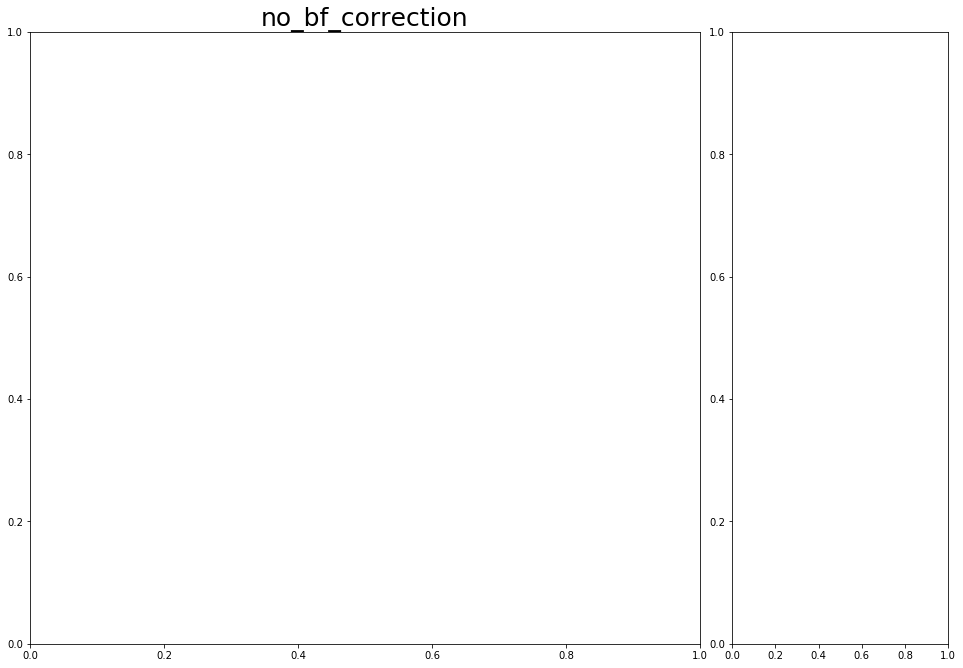

In [15]:
title = '{}'.format(run, detector)
saveName = os.path.join(outdir, title + '.pdf')
plot(all_mags, all_diffs, title, saveName)

------
#### With Brighter-Fatter Correction Applied

In [ ]:
repo = '/global/cscratch1/sd/wmwv/DC2/bf_kernel/imsim_repo/rerun/with_bf_correction'

In [ ]:
run = os.path.basename(repo)
print(run)

In [ ]:
butler = dafPersist.Butler(repo)

In [ ]:
mags = {}
diffs = {}

for detector in detectors:
    partial_data_id = {'detector': detector}
    mags[detector], diffs[detector] = get_shape_mag_diff(visits, partial_data_id)

In [ ]:
# Plot all combined measurements
all_mags = []
all_diffs = []
for detector in detectors:
    all_mags.extend(mags[detector])
    all_diffs.extend(diffs[detector])

all_mags = np.asarray(all_mags)
all_diffs = np.array(all_diffs)

title = '{}'.format(run, detector)
saveName = os.path.join(outdir, title + '.pdf')
plot(all_mags, all_diffs, title, saveName)

------